In [42]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm
import time

import lasagne
import lasagne.layers as layers

import pickle as pk

import pdb

In [2]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [3]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [4]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [5]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [6]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [7]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [8]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (1,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
        y[:4] = pos + shape
        y = y.astype(np.float64)
        y[[0,2]] /= im_shape[0]
        y[[1,3]] /= im_shape[1]
        y[-num_class + cls] += 1.
    return im / np.max(im), y

In [164]:
def gen_dataset(size, shape, max_obj=1):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(max_obj, 2, (20, 20), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X.astype(theano.config.floatX), y.astype(theano.config.floatX)

In [11]:
X,y = gen_dataset(10000, (100,100))

In [ ]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

print y[N,:4]

In [423]:
input = T.tensor4('input')
# input = theano.shared(X[:10], name='dat', borrow=True)

In [424]:
l1 = layers.InputLayer((None,1,100,100), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    8,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    8,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (3,3)
)
l5 = layers.Conv2DLayer(
    l4,
    16,
    (3,3)
)
l6 = layers.Conv2DLayer(
    l5,
    16,
    (3,3)
)
l7 = layers.Pool2DLayer(
    l6,
    (3,3)
)

le1 = layers.Conv2DLayer(
    l7,
    16,
    (3,3)
)
le2 = layers.Conv2DLayer(
    le1,
    16,
    (3,3)
)
le3 = layers.Pool2DLayer(
    le2,
    (2,2)
)

l8 = layers.DenseLayer(
    layers.dropout(le3, p=.2),
    100
)
l9 = layers.DenseLayer(
    layers.dropout(l8, p=.2),
    100,
)
l10 = layers.DenseLayer(
    layers.dropout(l9, p=.2),
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [425]:
with open('../weights/weights.pkl', 'rb') as f:
    weights = pk.load(f)
    weights = [w.astype(theano.config.floatX) for w in weights]

In [426]:
layers.set_all_param_values(l10, weights)

In [427]:
olayer = layers.DenseLayer(
    layers.dropout(l8, p=.2),
    2 * 2 * (10 + 2)
)

In [375]:
# with open('../weights/yolo_weights.pkl', 'wb') as f:
#     pk.dump(layers.get_all_param_values(olayer), f)
with open('../weights/yolo_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    weights = [w.astype(theano.config.floatX) for w in weights]
layers.set_all_param_values(olayer, weights)

In [428]:
net = {}
net['input'] = l1
net['l2'] = l2
net['l3'] = l3
net['l4'] = l4
net['l5'] = l5
net['l6'] = l6
net['l7'] = l7
net['le1'] = le1
net['le2'] = le2
net['le3'] = le3
net['l8'] = l8
net['output'] = olayer

In [429]:
reload(layers)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.py'>

In [430]:
yl = yolo.YoloObjectDetector(net, (None,1,100,100), 2, (2,2), 2)

In [379]:
# target = theano.shared(y[:10], name='gt', borrow=True)

In [548]:
train_loss, test_loss = yl.train(
    X[:5000],
    y[:5000],
    lr=1e-3,
    momentum=0.5,
    train_test_split=0.9,
    epochs=100,
    batch_size=100,
    lmbda_coord=5.,
    lmbda_noobj=.5,
    target=None
)

Getting cost...
Compiling...


  0%|          | 0/100 [00:00<?, ?it/s]

Beginning training...


  1%|          | 1/100 [00:17<29:06, 17.64s/it]

Epoch 0
------
Train Loss: 2.9053, Test Loss: 2.8310


  2%|▏         | 2/100 [00:35<28:49, 17.65s/it]

Epoch 1
------
Train Loss: 2.8896, Test Loss: 2.8317


  3%|▎         | 3/100 [00:52<28:33, 17.66s/it]

Epoch 2
------
Train Loss: 2.8903, Test Loss: 2.8248


  4%|▍         | 4/100 [01:10<28:16, 17.67s/it]

Epoch 3
------
Train Loss: 2.8883, Test Loss: 2.8271


  5%|▌         | 5/100 [01:28<27:59, 17.68s/it]

Epoch 4
------
Train Loss: 2.8828, Test Loss: 2.8313


  6%|▌         | 6/100 [01:46<27:42, 17.69s/it]

Epoch 5
------
Train Loss: 2.8813, Test Loss: 2.8212


  7%|▋         | 7/100 [02:03<27:25, 17.70s/it]

Epoch 6
------
Train Loss: 2.8813, Test Loss: 2.8235


  8%|▊         | 8/100 [02:21<27:07, 17.69s/it]

Epoch 7
------
Train Loss: 2.8774, Test Loss: 2.8284


  9%|▉         | 9/100 [02:39<26:50, 17.69s/it]

Epoch 8
------
Train Loss: 2.8760, Test Loss: 2.8199


 10%|█         | 10/100 [02:56<26:32, 17.70s/it]

Epoch 9
------
Train Loss: 2.8749, Test Loss: 2.8227


 11%|█         | 11/100 [03:14<26:14, 17.69s/it]

Epoch 10
------
Train Loss: 2.8717, Test Loss: 2.8319


 12%|█▏        | 12/100 [03:32<25:56, 17.69s/it]

Epoch 11
------
Train Loss: 2.8763, Test Loss: 2.8296


 13%|█▎        | 13/100 [03:49<25:39, 17.69s/it]

Epoch 12
------
Train Loss: 2.8724, Test Loss: 2.8395


 14%|█▍        | 14/100 [04:07<25:21, 17.69s/it]

Epoch 13
------
Train Loss: 2.8733, Test Loss: 2.8296


 15%|█▌        | 15/100 [04:25<25:04, 17.70s/it]

Epoch 14
------
Train Loss: 2.8691, Test Loss: 2.8180


 16%|█▌        | 16/100 [04:43<24:46, 17.70s/it]

Epoch 15
------
Train Loss: 2.8689, Test Loss: 2.8173


 17%|█▋        | 17/100 [05:00<24:28, 17.70s/it]

Epoch 16
------
Train Loss: 2.8665, Test Loss: 2.8193


 18%|█▊        | 18/100 [05:18<24:11, 17.70s/it]

Epoch 17
------
Train Loss: 2.8671, Test Loss: 2.8111


 19%|█▉        | 19/100 [05:36<23:53, 17.69s/it]

Epoch 18
------
Train Loss: 2.8673, Test Loss: 2.8136


 20%|██        | 20/100 [05:53<23:35, 17.69s/it]

Epoch 19
------
Train Loss: 2.8658, Test Loss: 2.8122


 21%|██        | 21/100 [06:11<23:17, 17.70s/it]

Epoch 20
------
Train Loss: 2.8662, Test Loss: 2.8164


 22%|██▏       | 22/100 [06:29<23:00, 17.70s/it]

Epoch 21
------
Train Loss: 2.8670, Test Loss: 2.8117


 23%|██▎       | 23/100 [06:46<22:42, 17.70s/it]

Epoch 22
------
Train Loss: 2.8637, Test Loss: 2.8368


 24%|██▍       | 24/100 [07:04<22:25, 17.71s/it]

Epoch 23
------
Train Loss: 2.8636, Test Loss: 2.8144


 25%|██▌       | 25/100 [07:22<22:07, 17.70s/it]

Epoch 24
------
Train Loss: 2.8590, Test Loss: 2.8149


 26%|██▌       | 26/100 [07:40<21:49, 17.70s/it]

Epoch 25
------
Train Loss: 2.8621, Test Loss: 2.8133


 27%|██▋       | 27/100 [07:57<21:32, 17.70s/it]

Epoch 26
------
Train Loss: 2.8593, Test Loss: 2.8124


 28%|██▊       | 28/100 [08:15<21:14, 17.70s/it]

Epoch 27
------
Train Loss: 2.8626, Test Loss: 2.8065


 29%|██▉       | 29/100 [08:33<20:56, 17.70s/it]

Epoch 28
------
Train Loss: 2.8585, Test Loss: 2.8069


 30%|███       | 30/100 [08:50<20:39, 17.70s/it]

Epoch 29
------
Train Loss: 2.8575, Test Loss: 2.8063


 31%|███       | 31/100 [09:08<20:21, 17.71s/it]

Epoch 30
------
Train Loss: 2.8573, Test Loss: 2.8164


 32%|███▏      | 32/100 [09:26<20:03, 17.71s/it]

Epoch 31
------
Train Loss: 2.8589, Test Loss: 2.8086


 33%|███▎      | 33/100 [09:43<19:46, 17.70s/it]

Epoch 32
------
Train Loss: 2.8567, Test Loss: 2.8080


 34%|███▍      | 34/100 [10:01<19:28, 17.70s/it]

Epoch 33
------
Train Loss: 2.8542, Test Loss: 2.8077


 35%|███▌      | 35/100 [10:19<19:10, 17.70s/it]

Epoch 34
------
Train Loss: 2.8543, Test Loss: 2.8072


 36%|███▌      | 36/100 [10:37<18:52, 17.70s/it]

Epoch 35
------
Train Loss: 2.8553, Test Loss: 2.8106


 37%|███▋      | 37/100 [10:54<18:35, 17.70s/it]

Epoch 36
------
Train Loss: 2.8537, Test Loss: 2.8095


 38%|███▊      | 38/100 [11:12<18:17, 17.70s/it]

Epoch 37
------
Train Loss: 2.8518, Test Loss: 2.8112


 39%|███▉      | 39/100 [11:30<17:59, 17.69s/it]

Epoch 38
------
Train Loss: 2.8521, Test Loss: 2.8074


 40%|████      | 40/100 [11:47<17:41, 17.69s/it]

Epoch 39
------
Train Loss: 2.8508, Test Loss: 2.8085


 41%|████      | 41/100 [12:05<17:24, 17.70s/it]

Epoch 40
------
Train Loss: 2.8521, Test Loss: 2.8076


 42%|████▏     | 42/100 [12:23<17:06, 17.70s/it]

Epoch 41
------
Train Loss: 2.8516, Test Loss: 2.8099


 43%|████▎     | 43/100 [12:40<16:48, 17.70s/it]

Epoch 42
------
Train Loss: 2.8506, Test Loss: 2.8013


 44%|████▍     | 44/100 [12:58<16:31, 17.70s/it]

Epoch 43
------
Train Loss: 2.8490, Test Loss: 2.8111


 45%|████▌     | 45/100 [13:16<16:13, 17.70s/it]

Epoch 44
------
Train Loss: 2.8508, Test Loss: 2.8018


 46%|████▌     | 46/100 [13:34<15:55, 17.69s/it]

Epoch 45
------
Train Loss: 2.8486, Test Loss: 2.8018


KeyboardInterrupt: 

Changed the regularization parameter to improve the classification accuracy.

In [433]:
testl, trainl = test_loss, train_loss
# testl, trainl = np.concatenate((testl, test_loss)), np.concatenate((trainl, train_loss))

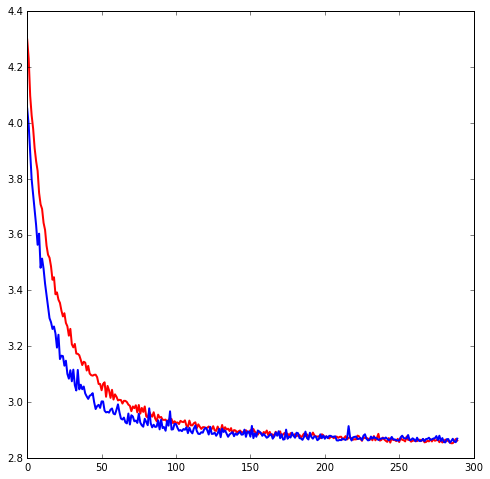

In [434]:
plt.figure(figsize=(8,8))
plt.plot(trainl[10:], 'r', linewidth=2.0)
plt.plot(testl[10:], 'b', linewidth=2.0)
plt.show()

In [549]:
pred_fn = theano.function([yl.input], yl.output)

In [632]:
Xtest, ytest = gen_dataset(1000, (100,100), max_obj=1)

In [633]:
ti = time.time()
tmp = pred_fn(Xtest[:500])
tf = time.time()
print ((tf - ti) / tmp.shape[0])

0.000285314083099


(array([ 0.5       ,  0.15840399,  0.60549641,  0.5       ], dtype=float32), array([ 0.989079  ,  0.01092099], dtype=float32), 0.57308316)
[ 0.34        0.02        0.43000001  0.77999997]
0.994605660439
0.991789340973
0.989078998566
0.99066567421


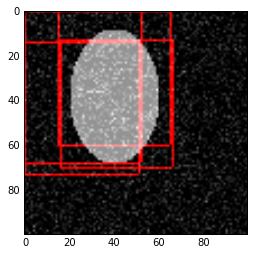

In [659]:
N = np.int_(tmp.shape[0] * np.random.rand())
best, confs = find_best_coords_2(tmp[N], (100,100))
im = Xtest[N,0]
for i in range(best.shape[0]):
    im = draw_coords(im, best[i])
plt.imshow(im)
print find_best_coords(tmp[N], (100,100))
print y[N,:4]
for i in range(confs.size):
    print confs[i]
# prb = np.max(probs)
# idx = np.argmax(probs)
# if idx == 0:
#     print('Circle with confidence: %.3f' % prb)
# else:
#     print('Triangle with confidence: %.3f' % prb)
# print iou

In [635]:
def find_best_coords(output, shape):
    idx = np.argmax(output[[4,9],:,:])
    coord = np.unravel_index(idx, (2,2,2))
    best = np.copy(output[coord[0] * 5:coord[0]*5 + 4, coord[1], coord[2]])
    best[0] += float(coord[1]) / 2
    best[1] += float(coord[2]) / 2
    return best, output[-2:,coord[1],coord[2]], output[[4,9],:,:][coord[0],coord[1],coord[2]]

In [455]:
def find_best_coords_2(output, shape):
    best = np.zeros((4,4))
    confs = np.zeros((4,))
    cnt = 0
    for i in range(2):
        for j in range(2):
            pred = output[:,i,j]
            idx = np.argmax(pred[[4,9]])
            coord = pred[idx * 5:idx*5 + 4]
            conf = np.max(pred[-2:]) #* pred[idx*5 + 4]
#             conf = pred[idx*5 + 4]
            best[cnt] = coord
            confs[cnt] = conf
            cnt += 1
    return best, confs

In [163]:
find_best_coords_2(tmp[N], (100,100))

(array([[ 0.61500818,  0.        ,  0.5       ,  0.87811464],
        [ 0.56815207,  0.        ,  0.5       ,  0.84476751],
        [ 0.        ,  0.        ,  0.5       ,  0.81068289],
        [ 0.        ,  0.        ,  0.5       ,  0.87202495]]),
 array([ 0.49909076,  0.49899533,  0.49933022,  0.49897981]))

In [175]:
def draw_coords(im, coord):
    coord[[0,2]] *= im.shape[0]
    coord[[1,3]] *= im.shape[1]
    coord = coord.astype(np.int32)
    if im.shape.__len__() < 3:
        im = np.copy(im)
        im = im.reshape(im.shape + (1,))
        im = np.concatenate((im,im,im), axis=2)
    def bound(num, lb, ub):
        return min(ub, max(num,lb))
    ri,rf = bound(coord[0], 0, im.shape[0]-1), bound(coord[0]+coord[2], 0, im.shape[0]-1)
    ci,cf = bound(coord[1], 0, im.shape[1]-1), bound(coord[1]+coord[3], 0, im.shape[1]-1)
    im[ri:rf, ci,0] = 1.0
    im[ri:rf, cf,0] = 1.0
    im[ri, ci:cf,0] = 1.0
    im[rf, ci:cf,0] = 1.0
    return im

In [ ]:
a = draw_coords(X[N,0], find_best_coords(tmp[N], (100,100))[0])

In [ ]:
a.shape

In [ ]:
plt.imshow(a)

In [ ]:
print find_best_coords(tmp[N], (100,100))

In [ ]:
np.argmax(tmp[0,[4,9],:,:])

In [ ]:
np.unravel_index(4, (2,2,2))

In [ ]:
tmp[0,[4,9],:,:][1,0,0]

In [ ]:
act_fn = theano.function([input], layers.get_output(le3))

In [ ]:
tmp = act_fn(X[:20])

In [ ]:
tmp.max()

In [ ]:
Xtest, ytest = gen_dataset(100, (100,100))

In [ ]:
preds = pred_fn(Xtest)

In [ ]:
N = np.int_(Xtest.shape[0] * np.random.rand())
fig = plt.figure(figsize=(7,7))
plt.imshow(Xtest[N,0], 'gray')
plt.show()

for i in range(2):
    for j in range(2):
        print preds[N,:,i,j]

In [ ]:
ytest[N]